In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

In [3]:
mypath = '/content/drive/MyDrive/SOS/TRAIN'

In [4]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [5]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
# df = pd.DataFrame({"path":full_path,'file_name':file_name})
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
NONE    36
O       48
S       41
dtype: int64

In [ ]:
#cek sample datanya
df.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/TRAIN/S/body white ...,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/TRAIN/S/body dot (2...,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/TRAIN/S/body dot (3...,body dot (3).jpg,S


In [6]:
import cv2

# check image shape-nya
img = cv2.imread('/content/drive/MyDrive/SOS/TRAIN/S/WIN_20220724_06_24_15_Pro.jpg')
print(type(img))
# <class 'numpy.ndarray'>

print(img.shape)
# (788, 789, 3)

<class 'numpy.ndarray'>
(240, 320, 3)


In [ ]:
s = df.loc[df['tag'] == 'S']
s.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/TRAIN/S/body white ...,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/TRAIN/S/body dot (2...,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/TRAIN/S/body dot (3...,body dot (3).jpg,S


In [ ]:
o = df.loc[df['tag'] == 'O']
o.head()

,path,file_name,tag
41,/content/drive/MyDrive/SOS/TRAIN/O/body dot (4...,body dot (4).jpg,O
42,/content/drive/MyDrive/SOS/TRAIN/O/wall white ...,wall white (4).jpg,O
43,/content/drive/MyDrive/SOS/TRAIN/O/body white ...,body white (3).jpg,O
44,/content/drive/MyDrive/SOS/TRAIN/O/body white ...,body white (2).jpg,O
45,/content/drive/MyDrive/SOS/TRAIN/O/body white ...,body white (4).jpg,O


In [ ]:
none = df.loc[df['tag'] == 'NONE']
none.head()

,path,file_name,tag
89,/content/drive/MyDrive/SOS/TRAIN/NONE/IMG_0945...,IMG_0945.JPG,NONE
90,/content/drive/MyDrive/SOS/TRAIN/NONE/IMG_0947...,IMG_0947.JPG,NONE
91,/content/drive/MyDrive/SOS/TRAIN/NONE/WIN_2022...,WIN_20220724_06_30_31_Pro.jpg,NONE
92,/content/drive/MyDrive/SOS/TRAIN/NONE/WIN_2022...,WIN_20220724_06_30_34_Pro.jpg,NONE
93,/content/drive/MyDrive/SOS/TRAIN/NONE/WIN_2022...,WIN_20220724_06_30_37_Pro.jpg,NONE


In [7]:
df = pd.concat([s, o, none], ignore_index=True)
df.head()

NameError: ignored

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [17]:
import tensorflow as tf
from tensorflow import keras

train_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 125 files belonging to 3 classes.
Using 100 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 125 files belonging to 3 classes.
Using 25 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['NONE', 'O', 'S']


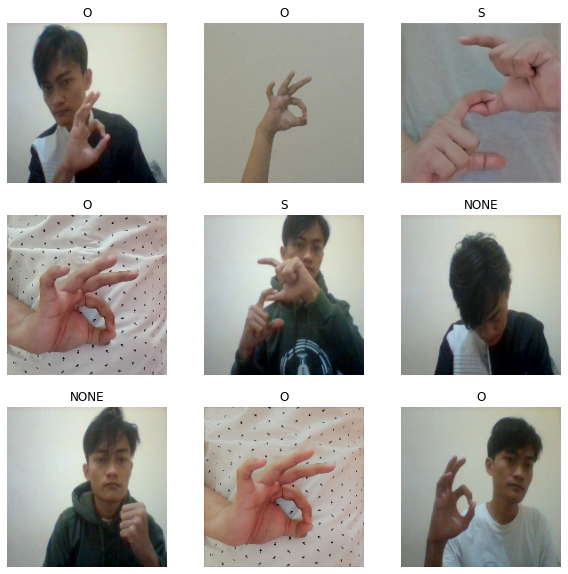

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [21]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.90682644


In [ ]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

tf.keras.backend.clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
# Create Model
size_img = (img_height, img_width, 3)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = len(class_names)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=size_img))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 64)        1

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 12s 3s/step - loss: 41.7509 - accuracy: 0.3700 - val_loss: 17.9772 - val_accuracy: 0.1200
Epoch 2/15
4/4 [==============================] - 7s 2s/step - loss: 15.7491 - accuracy: 0.3600 - val_loss: 14.4552 - val_accuracy: 0.1200
Epoch 3/15
4/4 [==============================] - 7s 2s/step - loss: 6.1316 - accuracy: 0.4000 - val_loss: 1.5904 - val_accuracy: 0.5200
Epoch 4/15
4/4 [==============================] - 7s 2s/step - loss: 1.2065 - accuracy: 0.5600 - val_loss: 0.9353 - val_accuracy: 0.5600
Epoch 5/15
4/4 [==============================] - 7s 2s/step - loss: 1.2879 - accuracy: 0.5400 - val_loss: 0.6050 - val_accuracy: 0.7600
Epoch 6/15
4/4 [==============================] - 7s 2s/step - loss: 0.8275 - accuracy: 0.6900 - val_loss: 0.6817 - val_accuracy: 0.6400
Epoch 7/15
4/4 [==============================] - 9s 2s/step - loss: 0.6212 - accuracy: 0.7700 - val_loss: 0.8466 - val_accuracy: 0.8000
Epoch 8/15
4/4 [==============================]

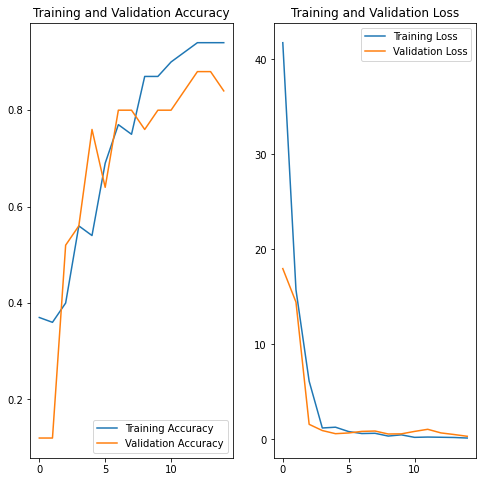

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#model.save('/content/drive/MyDrive/Model_dis_2/model_baru.h5')

# Using Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

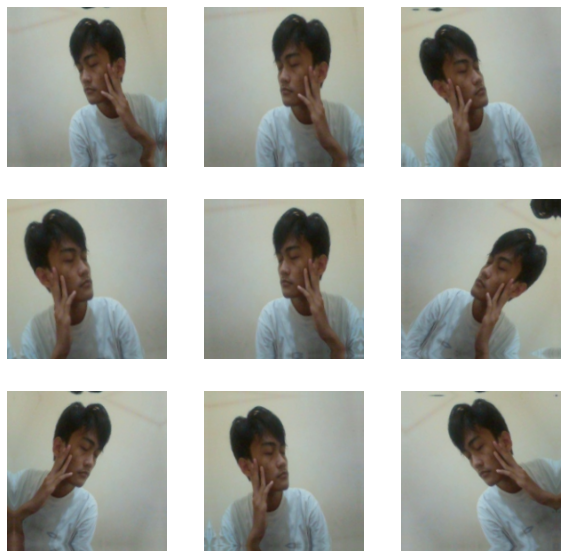

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
4/4 [==============================] - 5s 1s/step - loss: 1.3498 - accuracy: 0.3500 - val_loss: 1.2708 - val_accuracy: 0.1200
Epoch 2/15
4/4 [==============================] - 4s 861ms/step - loss: 1.1120 - accuracy: 0.3800 - val_loss: 1.0888 - val_accuracy: 0.4400
Epoch 3/15
4/4 [==============================] - 4s 852ms/step - loss: 1.0911 - accuracy: 0.4900 - val_loss: 1.0719 - val_accuracy: 0.4400
Epoch 4/15
4/4 [==============================] - 4s 857ms/step - loss: 1.0878 - accuracy: 0.3300 - val_loss: 1.0329 - val_accuracy: 0.6400
Epoch 5/15
4/4 [==============================] - 4s 1s/step - loss: 1.0787 - accuracy: 0.3800 - val_loss: 1.0372 - val_accuracy: 0.7200
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 1.0697 - accuracy: 0.4500 - val_loss: 0.9950 - val_accuracy: 0.6400
Epoch 7/15
4/4 [==============================] - 4s 1s/step - loss: 1.0351 - accuracy: 0.5100 - val_loss: 1.0044 - val_accuracy: 0.4400
Epoch 8/15
4/4 [================

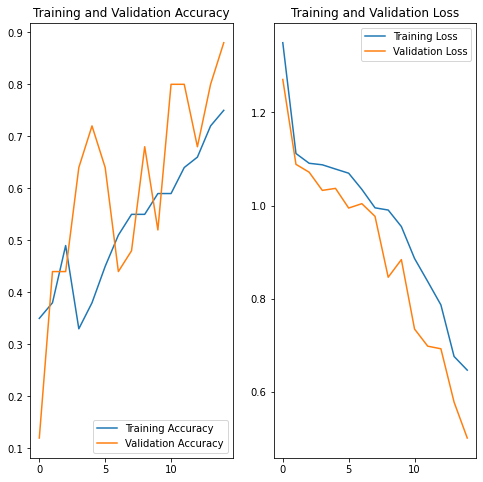

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Test Image

In [22]:
import tensorflow as tf
from tensorflow import keras
dirpath = '/content/drive/MyDrive/SOS/TRAIN/S/WIN_20220724_06_24_15_Pro.jpg'
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/model_baru.h5')
img = tf.keras.utils.load_img(
    dirpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to S with a 95.19 percent confidence.


In [23]:
# score = tf.nn.softmax(classes[0])
# 100 * np.max(score)

In [24]:
# Test image in folder 'test'

size_img = (img_height, img_width, 3)

from keras.preprocessing import image
import numpy as np
import os
directory = '/content/drive/MyDrive/SOS/TEST/'
name_class = ['NONE', 'O', 'S']
image_name = []
images = []
collect_img = []
count_img = 3
y_actual = []
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/model_baru.h5')
for kelas in name_class:
  list_file = sorted(os.listdir(os.path.join(directory,kelas)))
  for img in list_file[:count_img]:
    image_name.append(img)
    img = os.path.join(directory,kelas, img)
    print(img)
    img = image.load_img(img, target_size=(size_img))
    img_np = image.img_to_array(img)
    img = np.expand_dims(img_np, axis=0)
    images.append(img)
    collect_img.append(img_np)
    y_actual.append(kelas)

images = np.vstack(images)
classes = model.predict(images)



/content/drive/MyDrive/SOS/TEST/NONE/WIN_20220724_07_54_00_Pro.jpg
/content/drive/MyDrive/SOS/TEST/NONE/WIN_20220724_07_55_01_Pro.jpg
/content/drive/MyDrive/SOS/TEST/NONE/WIN_20220724_07_55_24_Pro.jpg
/content/drive/MyDrive/SOS/TEST/O/WIN_20220724_07_53_01_Pro.jpg
/content/drive/MyDrive/SOS/TEST/O/WIN_20220724_07_53_52_Pro.jpg
/content/drive/MyDrive/SOS/TEST/O/WIN_20220724_07_53_56_Pro.jpg
/content/drive/MyDrive/SOS/TEST/S/WIN_20220724_07_53_39_Pro.jpg
/content/drive/MyDrive/SOS/TEST/S/WIN_20220724_07_53_44_Pro.jpg
/content/drive/MyDrive/SOS/TEST/S/WIN_20220724_07_53_49_Pro.jpg


In [25]:
y_predict = []
for i in range(len(collect_img)):
  y_predict.append(class_names[np.argmax(classes[i])])

print(y_actual)
print(y_predict)

['NONE', 'NONE', 'NONE', 'O', 'O', 'O', 'S', 'S', 'S']
['NONE', 'NONE', 'O', 'O', 'O', 'O', 'S', 'S', 'O']


In [ ]:
print(classes)

[[ 1.917403    1.3200727  -3.5426753 ]
 [ 1.7775584   1.7468691  -3.6858873 ]
 [ 0.67610043  2.2156196  -1.8137889 ]
 [-3.110489    4.311087    0.5280337 ]
 [-2.619392    6.0611534  -2.1790416 ]
 [-0.15352747  3.2630577  -1.901029  ]
 [-3.9706776   3.7340667   4.153943  ]
 [-2.4467895   3.1711826   3.5363417 ]
 [-1.1579986   2.6348197   1.5668203 ]]


0
0
1
1
1
1
2
2
1


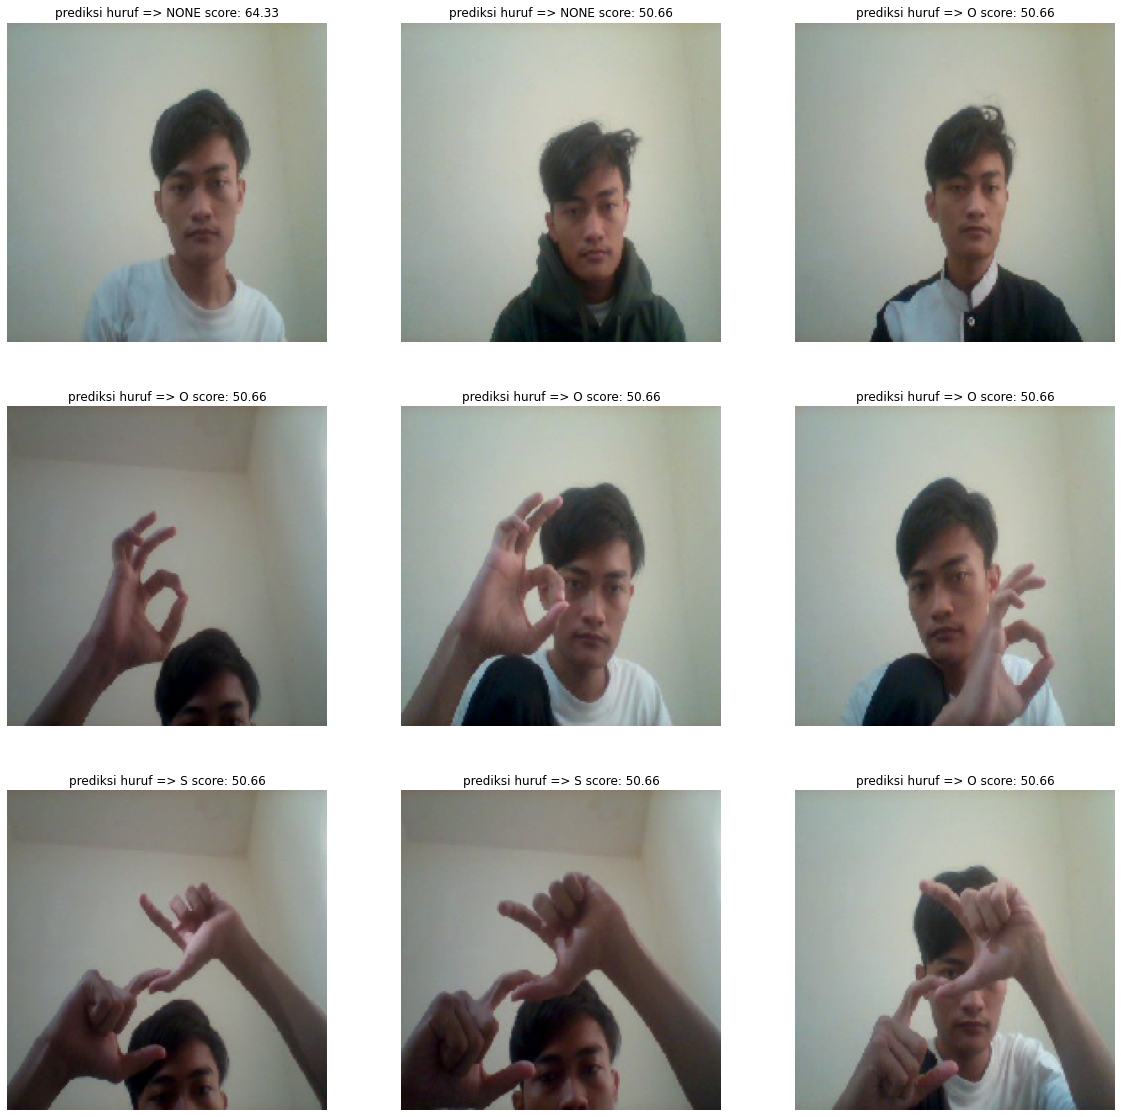

In [28]:
plt.figure(figsize=(20, 20))
for i in range(len(collect_img)):
    idX_class = classes[i]
    ax = plt.subplot(3, 3, i + 1)
    print(np.argmax(idX_class))
    if np.argmax(idX_class) == 0:
      score = tf.nn.softmax(idX_class)
      # print(i+1, image_name[i],'    ', name_class[0])
      plt.imshow(collect_img[i].astype("uint8"))
      # plt.title(image_name[i]+'prediksi huruf => '+name_class[0]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.title('prediksi huruf => '+name_class[0]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.axis("off")

    elif np.argmax(idX_class) == 1:
      # print(i+1, image_name[i],'    ', name_class[1])
      plt.imshow(collect_img[i].astype("uint8"))
      # plt.title(image_name[i]+'prediksi huruf => '+name_class[1]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.title('prediksi huruf => '+name_class[1]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.axis("off")
      
    elif np.argmax(idX_class) == 2:
      # print(i+1, image_name[i],'    ', name_class[2])
      plt.imshow(collect_img[i].astype("uint8"))
      # plt.title(image_name[i]+'prediksi huruf => '+name_class[2]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.title('prediksi huruf => '+name_class[2]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.axis("off")

# Evaluasi Model


Model merupakan Multiclass Classification (MC) dengan 3 kelas yaitu None (tidak terdeteksi huruf), huruf O, dan huruf S.
Metrics yang digunakan untuk mengevaluasi model ini yaitu Precision, Recall, F1-Score, ROC AUC Score, Cohen Kappa Score, Koefisien Korelasi Matthew, dan Log Loss.

## Confusion Matrix

Model diharapkan dapat lebih mendeteksi adanya huruf daripada tidak ada huruf sehingga kelas S dan O diidentifikasi sebagai kelas positif dan None sebagai kelas negatif.
Sehingga dapat dibagi menjadi beberapa kategori yaitu:
- **True positives**, type 1: jika gambar huruf S diprediksi sebagai huruf S
- **True positives**, type 2: jika gambar huruf O diprediksi sebagai huruf O
- **True negatives**: jika tidak ada huruf (None) diidentifikasi sebagai None
- **False positives**: jika tidak ada huruf (None) diprediksi sebagai huruf (S atau O)
- **False negatives**: jika huruf S atau O dideteksi sebagai None

Pada evaluasi model ini, akan digunakan pendekatan **One-vs-Rest (OVR)**.

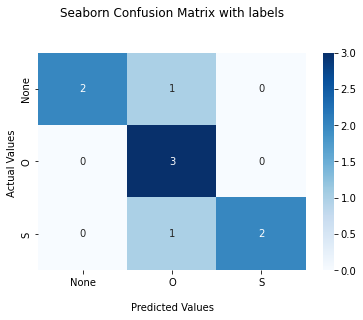

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_actual,y_predict)


ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['None','O','S'])
ax.yaxis.set_ticklabels(['None','O','S'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Precision, Recall, F1-Score

**Precision** <br>
> $Precision = \frac{TP}{TP+TN}$

**Recall** <br>
> $Recall = \frac{TP}{TP+FN}$

**F1-Score** <br>
> $F1\ Score = \frac{2*(precision*recall)}{precision+recall}$









In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predict, target_names=class_names))

              precision    recall  f1-score   support

        NONE       1.00      0.67      0.80         3
           O       0.60      1.00      0.75         3
           S       1.00      0.67      0.80         3

    accuracy                           0.78         9
   macro avg       0.87      0.78      0.78         9
weighted avg       0.87      0.78      0.78         9



## ROC_AUC_Score

In [58]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
clf = RF()
image_batch = image_batch.reshape(batch_size,3*img_height*img_width)
labels_batch = labels_batch.reshape(32)
clf.fit(image_batch,labels_batch)
y_preb_probs = clf.predict_proba(image_batch)
roc_auc_score(labels_batch, y_preb_probs, average="weighted", multi_class="ovr")


1.0

In [53]:
print(image_batch.shape)

(32, 180, 180, 3)


## Cohen-Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_actual, y_predict)


0.6666666666666667

## Koefisien korelasi Matthew

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_actual, y_predict)

0.7071067811865476

## Log loss

In [60]:
from sklearn.metrics import log_loss
log_loss(labels_batch, y_preb_probs)


0.19675333430455338